## Goal: If we have 28 samples and have to choose to 

- 1. do lr rna-seq for 2 samples (only use GRCh38) or
- 2. do lr-rna-seq for 1 sample w/ personalized GRCh38 transcript discovery, what's best?

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import itertools
import os
import matplotlib.pyplot as plt
import yaml
from snakemake.io import expand
import pyranges as pr
from pyfaidx import Fasta
from mizani.formatters import percent_format
from scipy import stats


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

from plotnine import *

In [2]:
def my_theme(base_size=11, w=4, h=3):
    """
    Custom plotnine theme with:
    - White background
    - Clean styling
    - Axes and ticks retained

    Parameters:
    - base_size: Base font size

    Returns:
    - plotnine.theme object
    """
    return (
        theme_minimal(base_size=base_size)
        + theme(
            # White background
            panel_background=element_rect(fill='white', color=None),
            plot_background=element_rect(fill='white', color=None),

            # Remove grid lines
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),

            # Keep axis lines & ticks (don't blank them)
            axis_line=element_line(color='black'),
            axis_ticks=element_line(color='black'),

            plot_title=element_text(hjust=0.5, family='Helvetica'),
            axis_title_x=element_text(hjust=0.5, family='Helvetica'),
            axis_title_y=element_text(hjust=0.5, margin={'t':0, 'r':-2, 'b':0, 'l':0}, family='Helvetica'),
            
            # Styling text
            legend_title=element_blank(),
            axis_title=element_text(size=base_size + 1, family='Helvetica'),
            legend_text=element_text(size=base_size-2, family='Helvetica'),
            axis_text=element_text(size=base_size, color='black', family='Helvetica'),
            strip_text_x=element_text(size=base_size-1),
            strip_text_y=element_text(size=base_size-1),
            figure_size=(w, h),  # Controls plot dimensions (width x height in inches)
            plot_margin=0.05      # Shrinks surrounding white space
        )
    )

In [3]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [4]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df.columns
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID',
          'map_reads_assemblymap','lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

In [5]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

df['n_ic'] = df.groupby('cell_line_id')['ic_id'].transform('nunique')         
df = df[['n_ic', 'cell_line_id']].drop_duplicates()

assert len(df.index) == 30
df = df.sort_values(by='n_ic', ascending=False)
cell_line_order = df.cell_line_id.tolist()
# cell_line_order

In [6]:
# def process_ic_summary(meta_df, 
#                        nov='all',
#                        genome='hg38',
#                        order=None):
#     """
#     Paramters:
#         nov (str): Novelty of reported ICs {'all', 'nov'}
#         genome (str): Genome for detection of ICs {'hg38', 'pers'}
#     Returns:
#         temp (pandas DataFrame): ??
#         big_df (pandas DataFrame): Some sort of summary dataframe
#         samples_2 (list of str): Cell line ids of 2 missing samples
#         samples_28 (list of str): Cell line ids of 28 included samples
#     """

#     file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
#     df = pd.read_csv(file)
#     df.drop('Unnamed: 0', axis=1, inplace=True)
#     df['detected'] = True
    
#     # 1.5 only novel ics and count per cell line
#     if nov == 'nov':
#         print(len(df.index))
#         temp = df.loc[(df.structural_category!='full-splice_match')&\
#                       (df.structural_category!='incomplete-splice_match')]
#         print(len(temp.index))
#     elif nov == 'all':
#         temp = df.copy(deep=True)
    
#     # get only the detection from mapping
#     temp = temp[['ic_id', 'cell_line_id', 'map_genome', 'detected']]
#     temp = temp.drop_duplicates()
#     temp = temp.pivot(index=['ic_id', 'cell_line_id'], 
#                     columns=['map_genome'],
#                     values=['detected'])
    
#     # flatten
#     temp.columns = temp.columns.get_level_values(1)
#     temp.columns.name = None
    
#     # reset index to make it a flat DataFrame
#     temp = temp.reset_index()
    
#     # fill missing values with False
#     temp = temp.fillna(False)

    
#     if genome == 'pers':
#         # 1.75. get those that are detected in hap1/2 
#         temp = temp.loc[(temp.hap1+temp.hap2)>0]
#     elif genome == 'hg38': 
#         temp = temp.loc[(temp.hg38)==1]

#     temp['n_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')         
#     temp2 = temp[['cell_line_id', 'n_ic']]

#     # order by # of detected ICs if no explicit order is given, otherwise
#     # order by the given order
#     if not order:
#         temp2 = temp2.sort_values(by='n_ic', ascending=False)
#     else:
#         temp2['cell_line_id'] = pd.Categorical(temp2['cell_line_id'], categories=order, ordered=True)
#         temp2 = temp2.sort_values('cell_line_id')
    
#     temp2.drop_duplicates(inplace=True)
#     # order = temp2.cell_line_id.tolist()
#     temp.drop(['hap1', 'hap2', 'hg38', 'n_ic'], axis=1, inplace=True)
    
#     temp['detected'] = True
#     temp = temp.pivot(index='ic_id', columns='cell_line_id')
#     temp.columns.name = None
#     temp.columns = temp.columns.get_level_values(1)
#     temp.fillna(False, inplace=True)
    
#     temp = temp[order]
#     prev_ics = []
#     big_df = pd.DataFrame()
#     for i, c in enumerate(temp.columns):
#         temp2 = temp.loc[temp[c]==True]
#         pop = meta_df.loc[meta_df.cell_line_id_1000g==c, 'population'].values[0]
#         ics = temp2.index.tolist()
#         n = len(list(set(ics)-set(prev_ics)))
#         prev_ics += ics
#         # print(len(prev_ics))
#         temp3 = pd.DataFrame(data=[[n,i,pop,c]], columns=['n_added_uniq', 'n_samples', 'population', 'cell_line_id_1000g'])
#         big_df = pd.concat([big_df, temp3], axis=0)
        
#     big_df['genome'] = genome
#     big_df['ic_nov'] = nov
#     big_df['n_cumulative_ics'] = big_df.n_added_uniq.cumsum()

#     samples_28 = order[:28]
#     samples_2 = order[-2:]
    
#     return temp, big_df, samples_28, samples_2

## All ICs, personal genomes

In [8]:
# temp, big_df, samples_28, samples_2 = process_ic_summary(meta_df, 
#                        nov='all',
#                        genome='pers', 
#                        order=cell_line_order)

In [10]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df['detected'] = True
df = df.loc[df.sqanti_genome=='hg38']

columns = ['sample_28_index',
           'start_n_reads',
           'n_ic_start', 
           'start_genome',
           'n_ic_new',
           'new_strat',
           'wgs_sample_2_index',
           'new_n_reads',
           'ic_nov']

df2 = pd.DataFrame()
           
def add_vals(df, vals, columns):
    df2 = pd.DataFrame(data=[vals], columns=columns)
    df = pd.concat([df, df2], axis=0)
    return df

# loop through each start genome
for start_genome in ['hg38', 'pers']:

    # loop through ic novelty
    for nov in ['all', 'nov']:
    
        # loop through each combination
        combinations = list(itertools.combinations(cell_line_order, 28))
        for i, comb in enumerate(combinations):
            
            # reads 28 samples (starting reads)
            n_reads = meta_df.loc[meta_df['cell_line_id_1000g'].isin(comb)]
            assert len(n_reads.index) == 28
            start_n_reads = n_reads['map_reads_assemblymap'].sum()
        
            # number of relevant ics found using LR-RNA-seq + GRCh38 
            # for the starting 28 samples
            if nov == 'all' and start_genome == 'hg38':
                temp = df.loc[(df.map_genome=='hg38')&\
                              (df.cell_line_id.isin(comb))]
            elif nov == 'nov' and start_genome == 'hg38':
                 temp = df.loc[(df.map_genome=='hg38')&\
                               (df.cell_line_id.isin(comb))&\
                               (df.structural_category!='full-splice_match')&\
                               (df.structural_category!='incomplete-splice_match')]
            elif nov == 'all' and start_genome == 'pers':
                temp = df.loc[(df.map_genome.isin(['hap2', 'hap1']))&\
                              (df.cell_line_id.isin(comb))]
            elif nov == 'nov' and start_genome == 'pers':
                 temp = df.loc[(df.map_genome.isin(['hap2', 'hap1']))&\
                               (df.cell_line_id.isin(comb))&\
                               (df.structural_category!='full-splice_match')&\
                               (df.structural_category!='incomplete-splice_match')]
            assert len(temp.cell_line_id.unique()) == 28
            start_ics = temp.ic_id.unique()
            n_start_ics = len(temp.ic_id.unique())
                                        
            # missing samples
            samples_2 = list(set(cell_line_order)-set(comb))
        
            # reads 2 samples (# added reads)
            n_reads = meta_df.loc[meta_df['cell_line_id_1000g'].isin(samples_2)]
            assert len(n_reads.index) == 2
            new_n_reads = n_reads['map_reads_assemblymap'].sum()
        
            # 1. adding 2 more samples by LR-RNA-seq only 
            # (ie only using GRCh38 as a reference)

            if nov == 'all':
                temp = df.loc[(df.map_genome=='hg38')&\
                              (df.cell_line_id.isin(samples_2))]
            elif nov == 'nov':
                temp = df.loc[(df.map_genome=='hg38')&\
                               (df.cell_line_id.isin(samples_2))&\
                               (df.structural_category!='full-splice_match')&\
                               (df.structural_category!='incomplete-splice_match')]
            assert len(temp.cell_line_id.unique()) == 2
            ics_2_rna = temp.ic_id.unique().tolist()
            
            vals = [i, start_n_reads,
                    n_start_ics, start_genome, 
               len(list(set(ics_2_rna)-set(start_ics))), # increase in number, set difference
               'rna_2_samples', np.nan, new_n_reads, nov]
            df2 = add_vals(df2, vals, columns)
        
            # 2. adding 1 more sample by LR-RNA-seq + WGS
            # (ie using personal GRCh38 only as reference)
            for j, c_id in enumerate(samples_2):
                # reads 1 sample1
                n_reads = meta_df.loc[meta_df['cell_line_id_1000g'].isin([c_id])]
                assert len(n_reads.index) == 1
                new_n_reads = n_reads['map_reads_assemblymap'].sum()

                if nov == 'all':
                    temp = df.loc[(df.cell_line_id.isin([c_id]))&\
                                   (df.map_genome.isin(['hap2', 'hap1']))]
                elif nov == 'nov':
                    temp = df.loc[(df.cell_line_id.isin([c_id]))&\
                                  (df.map_genome.isin(['hap2', 'hap1']))&\
                                  (df.structural_category!='full-splice_match')&\
                                  (df.structural_category!='incomplete-splice_match')]
                    
                ics_1_wgs = temp.ic_id.unique().tolist()
                vals = [i, start_n_reads,
                        n_start_ics, start_genome, 
                   len(list(set(ics_1_wgs)-set(start_ics))), # increase in number, set difference
                   'wgs_1_sample', j, new_n_reads, nov]
                df2 = add_vals(df2, vals, columns)
        

In [11]:
# df2.to_csv('250714_28_sample_experiment.tsv', sep='\t')

In [15]:
len(df2[['sample_28_index', 'start_genome', 'ic_nov', 'wgs_sample_2_index']].drop_duplicates().index)

5220

## Make some plots for this

In [17]:
df = pd.read_csv('250714_28_sample_experiment.tsv', sep='\t')
df.head()

,Unnamed: 0,sample_28_index,start_n_reads,n_ic_start,start_genome,n_ic_new,new_strat,wgs_sample_2_index,new_n_reads,ic_nov
0,0,0,414179596.0,198058,hg38,2172,rna_2_samples,NaN,18086656.0,all
1,0,0,414179596.0,198058,hg38,1309,wgs_1_sample,0.0,8657393.0,all
2,0,0,414179596.0,198058,hg38,1252,wgs_1_sample,1.0,9429263.0,all
3,0,1,412497279.0,197712,hg38,2518,rna_2_samples,NaN,19768973.0,all
4,0,1,412497279.0,197712,hg38,1687,wgs_1_sample,0.0,10339710.0,all


In [66]:
# add some nice labels to use on plots instead 
df['start_genome_hr'] = df.start_genome.map({'hg38': 'Starting genome = GRCh38', 'pers': 'Starting genome = Personal'})
df['new_strat_hr'] = df.new_strat.map({'rna_2_samples': 'lrRNA-seq x2\nGRCh38\ntranscript discovery',
                                       'wgs_1_sample': 'lrRNA-seq + WGS x1\nPersonalized-GRCh38\ntranscript discovery'})
df['ic_nov_hr'] = df.ic_nov.map({'nov': 'Novel transcripts', 'all': 'All transcripts'})

In [80]:
# colors
c_dict = {}
c_dict['lrRNA-seq x2\nGRCh38\ntranscript discovery'] = '#ba4639'
c_dict['lrRNA-seq + WGS x1\nPersonalized-GRCh38\ntranscript discovery'] = '#42799a'

## How does number of reads relate to the number of ICs? (both pre and post)

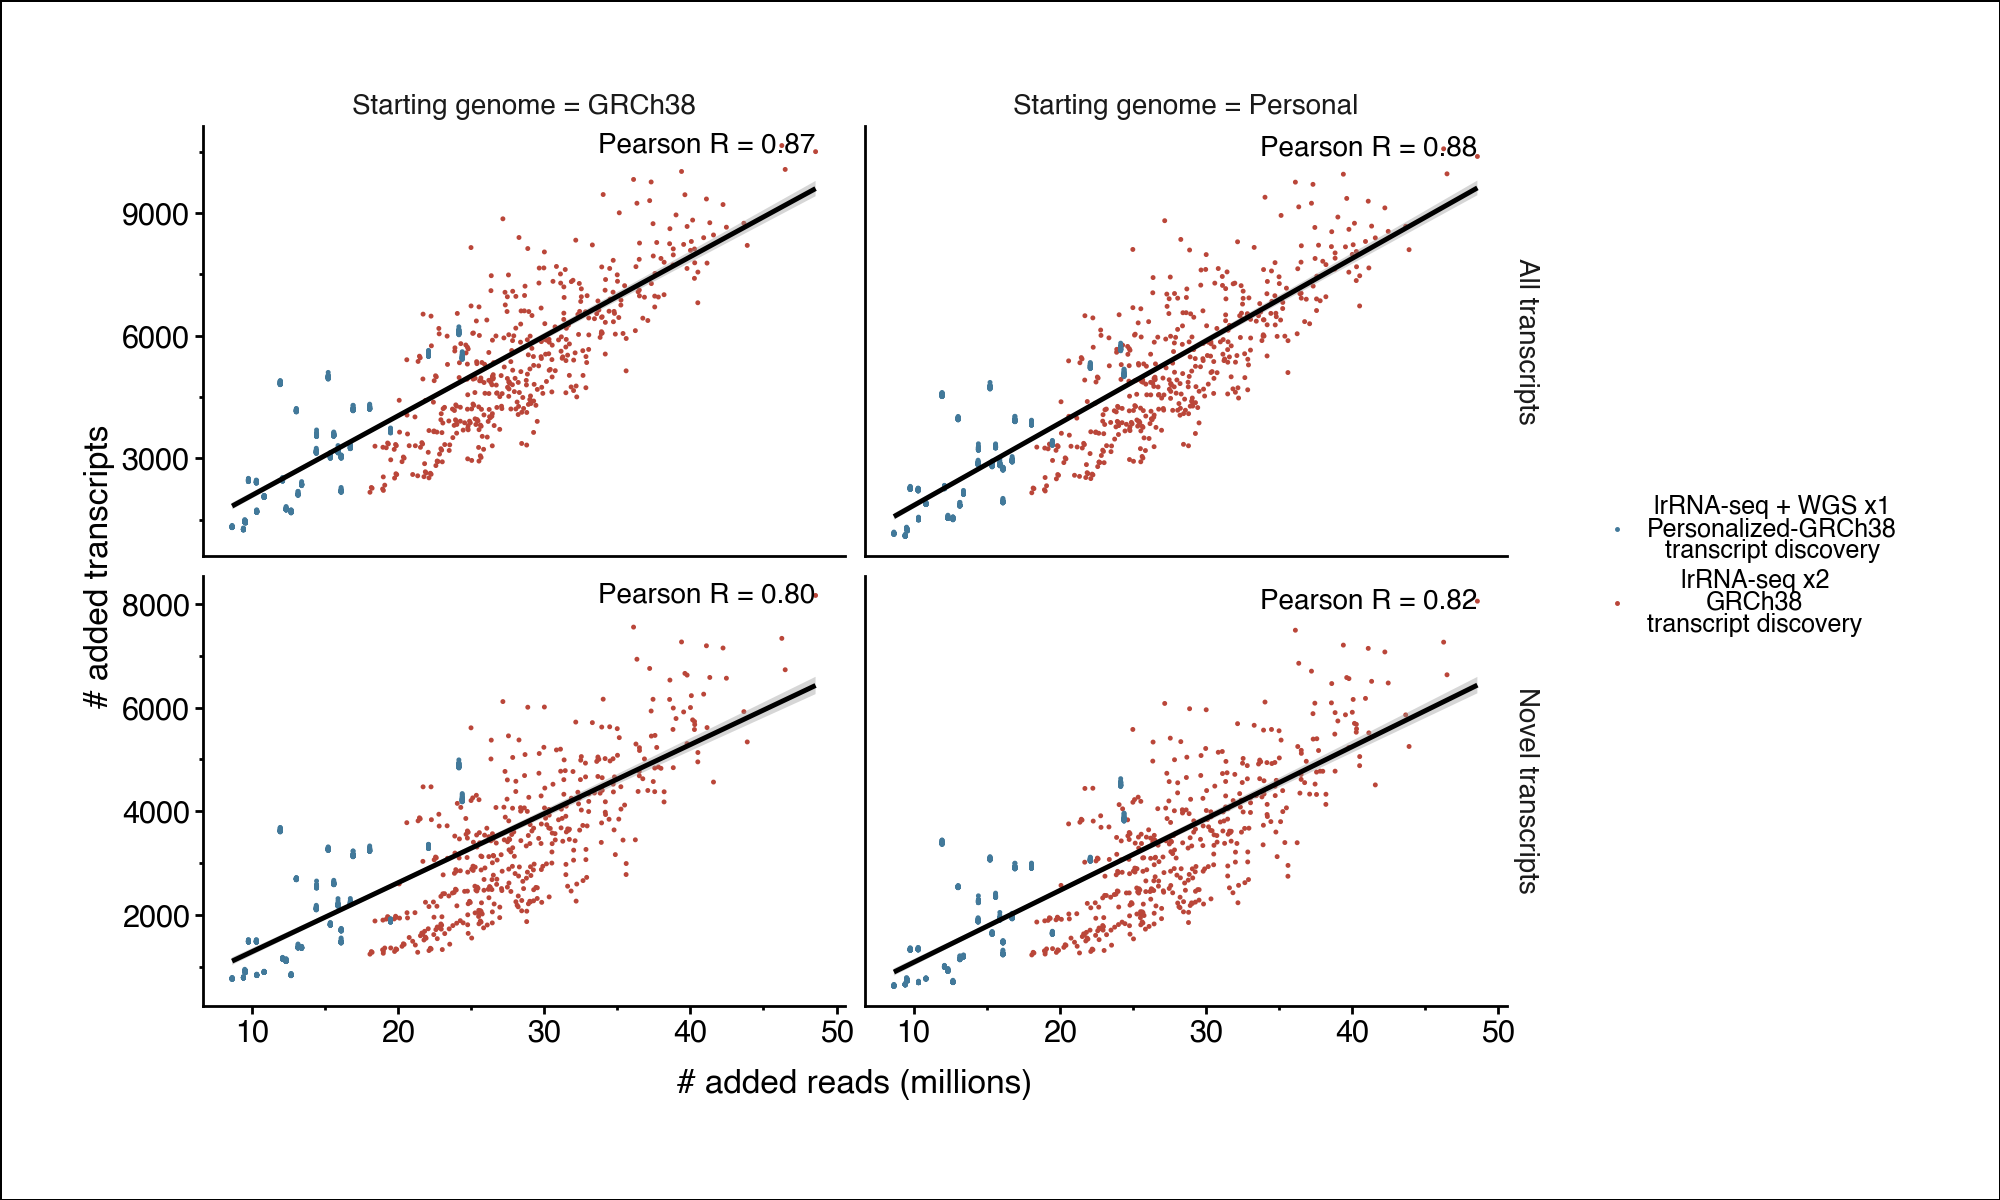

In [81]:
df['new_n_reads_mil'] = df.new_n_reads/1e6

facet_col = 'start_genome_hr'
facet_row = 'ic_nov_hr'
fill = 'new_strat_hr'
x = 'new_n_reads_mil'
y = 'n_ic_new'

anno_df = []
for (genome, nov), subdf in df.groupby([facet_col, facet_row]):
    r, p = st.pearsonr(subdf[x], subdf[y])
    label = f"Pearson R = {r:.2f}"
    x_pos = subdf[x].max()
    y_pos = subdf[y].max()
    anno_df.append({
        facet_col: genome,
        facet_row: nov,
        'label': label,
        'x': x_pos,
        'y': y_pos
    })
anno_df = pd.DataFrame(anno_df)


p = (ggplot(df, aes(x=x, y=y))
    + geom_point(aes(fill=fill), stroke=0, size=1)
    + scale_fill_manual(values=c_dict)
    + facet_grid(f'{facet_row}~{facet_col}', scales='free_y')
    + geom_smooth(method='lm')
    + geom_text(
        data=anno_df,
        mapping=aes(x='x', y='y', label='label'),
        inherit_aes=False,
        size=10,
        ha='right'
    )
    + my_theme(h=6, w=10)
    + labs(
        x='# added reads (millions)',
        y='# added transcripts',
        fill='Added samples strategy'
    ))
p.show()

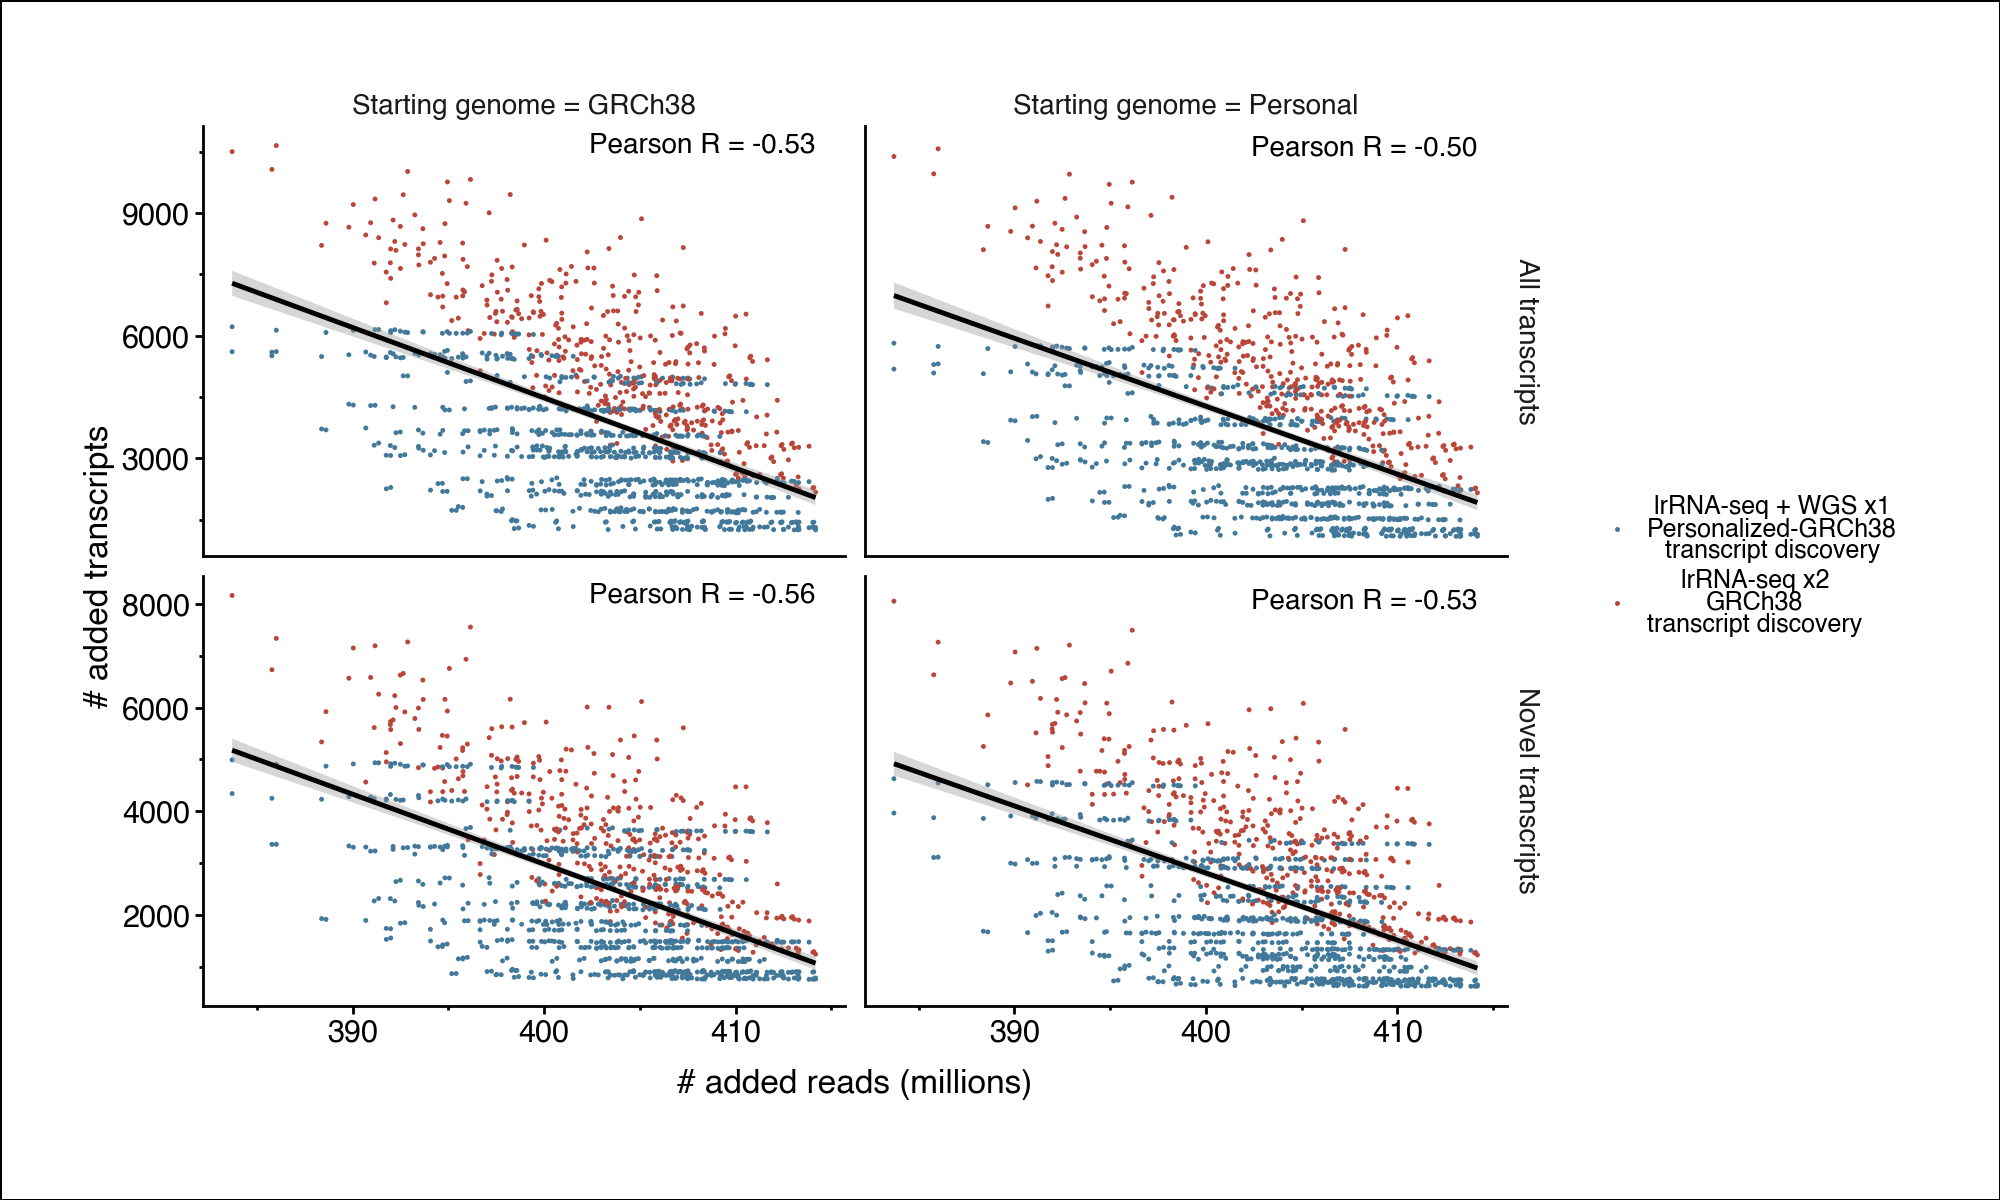

In [82]:
df['start_n_reads_mil'] = df.start_n_reads/1e6

facet_row = 'ic_nov_hr'
facet_col = 'start_genome_hr'
fill = 'new_strat_hr'
x = 'start_n_reads_mil'
y = 'n_ic_new'


anno_df = []
for (genome, nov), subdf in df.groupby([facet_col, facet_row]):
    r, p = st.pearsonr(subdf[x], subdf[y])
    label = f"Pearson R = {r:.2f}"
    x_pos = subdf[x].max()
    y_pos = subdf[y].max()
    anno_df.append({
        facet_col: genome,
        facet_row: nov,
        'label': label,
        'x': x_pos,
        'y': y_pos
    })
anno_df = pd.DataFrame(anno_df)


p = (ggplot(df, aes(x=x, y=y))
    + geom_point(aes(fill=fill), stroke=0, size=1)
    + scale_fill_manual(values=c_dict)
    + facet_grid(f'{facet_row}~{facet_col}', scales='free_y')
    + geom_smooth(method='lm')
    + geom_text(
        data=anno_df,
        mapping=aes(x='x', y='y', label='label'),
        inherit_aes=False,
        size=10,
        ha='right'
    )
    + my_theme(h=6, w=10)
    + labs(
        x='# added reads (millions)',
        y='# added transcripts',
        fill='Added samples strategy'
    ))
p.show()

## Median numbers for each strategy

In [78]:
df[['start_genome', 'new_strat', 'n_ic_new', 'ic_nov']].groupby(['new_strat', 'ic_nov', 'start_genome']).median()

n_ic_new
new_strat     ic_nov start_genome          
rna_2_samples all    hg38            5344.0
                     pers            5311.0
              nov    hg38            3415.0
                     pers            3382.0
wgs_1_sample  all    hg38            3040.5
                     pers            2790.0
              nov    hg38            1774.0
                     pers            1568.0

## Distribution of number of added ICs per strategy

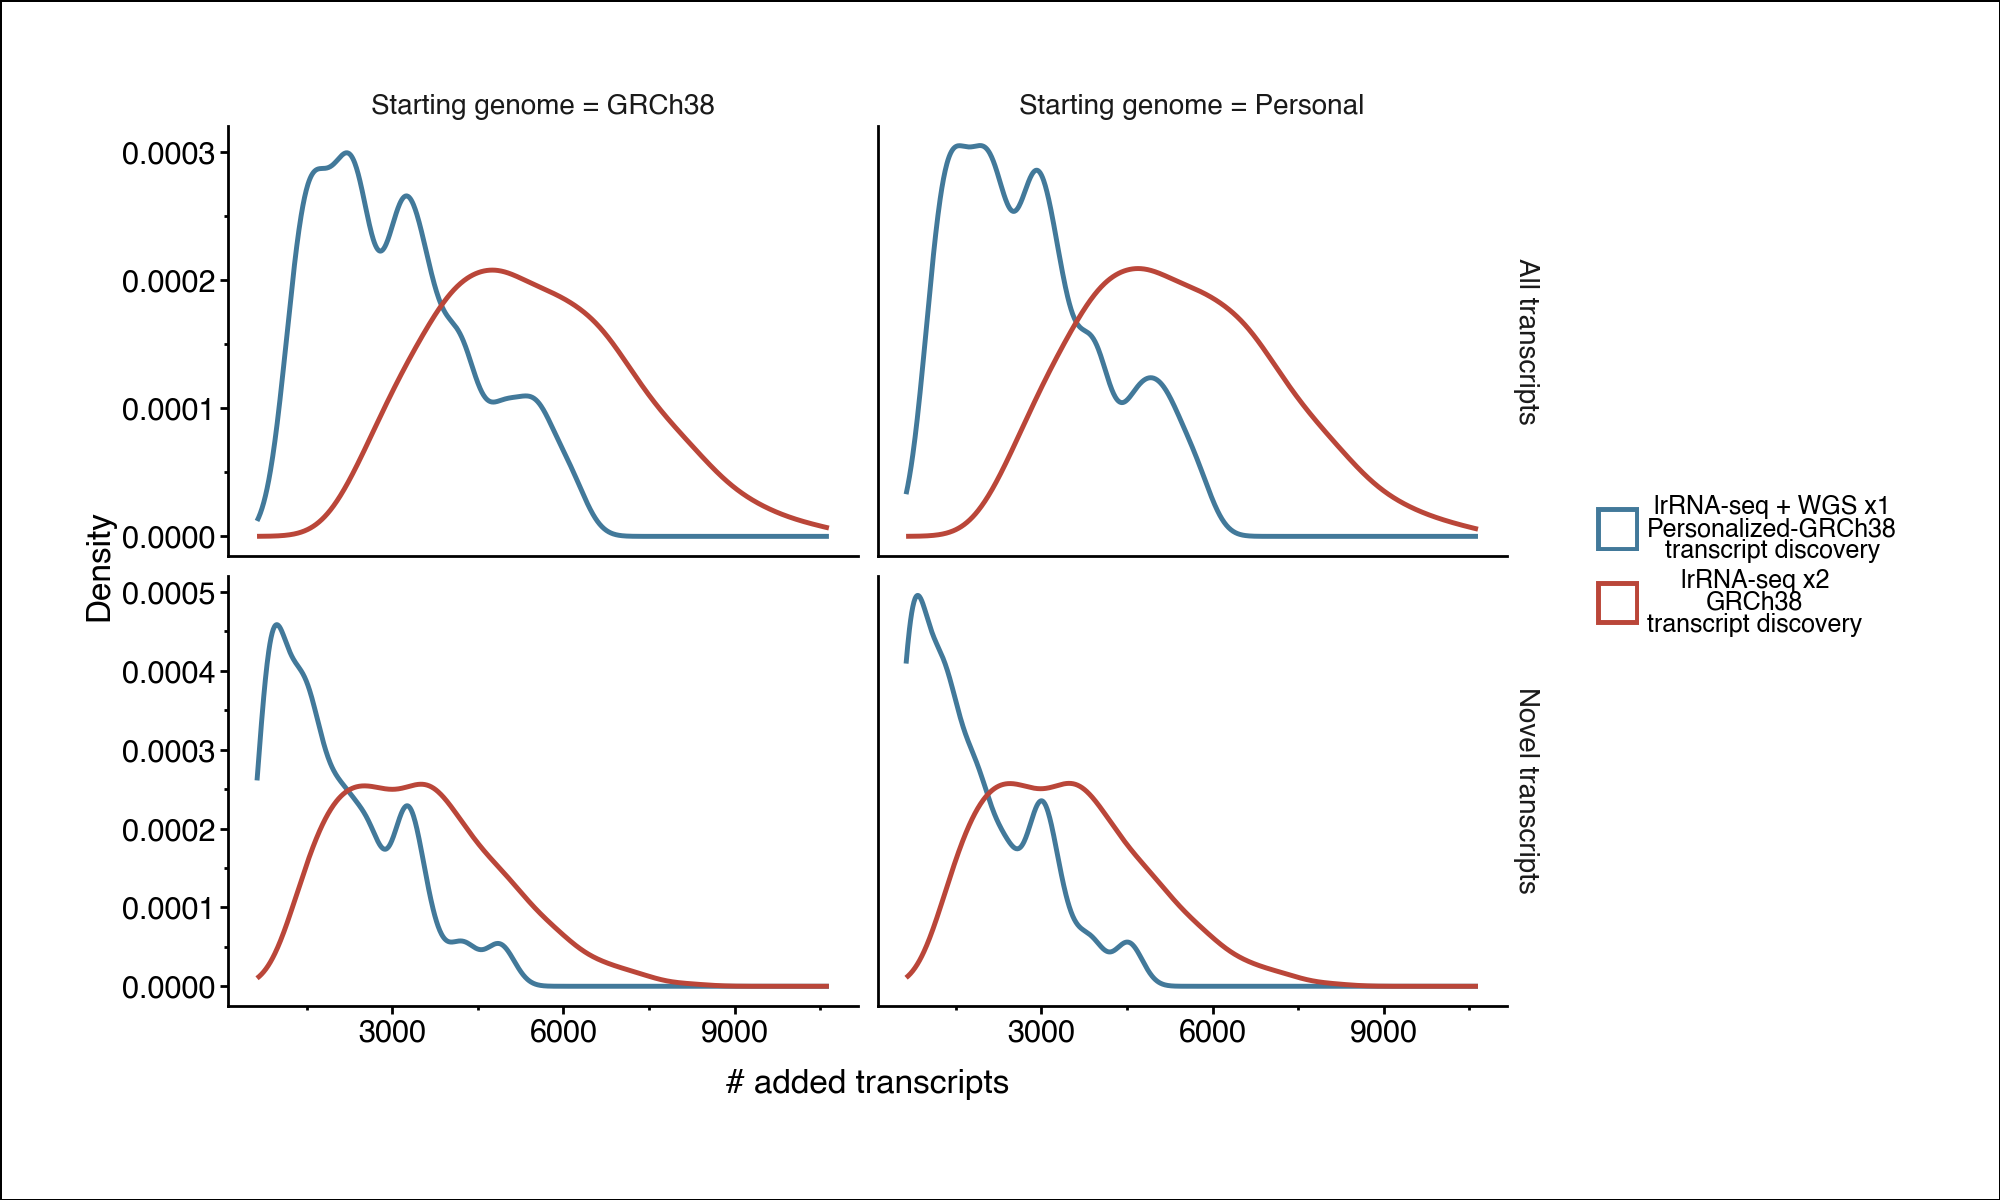

In [90]:
facet_row = 'ic_nov_hr'
facet_col = 'start_genome_hr'
color = 'new_strat_hr'
x = 'n_ic_new'

p = (ggplot(df, aes(x=x))
    + geom_density(aes(color=color), size=1)
    + scale_color_manual(values=c_dict)
    + facet_grid(f'{facet_row}~{facet_col}', scales='free_y')
    + my_theme(h=6, w=10)
    + labs(
        x='# added transcripts',
        y='Density',
        fill='Added samples strategy'
    ))
p.show()

## Also boxplots

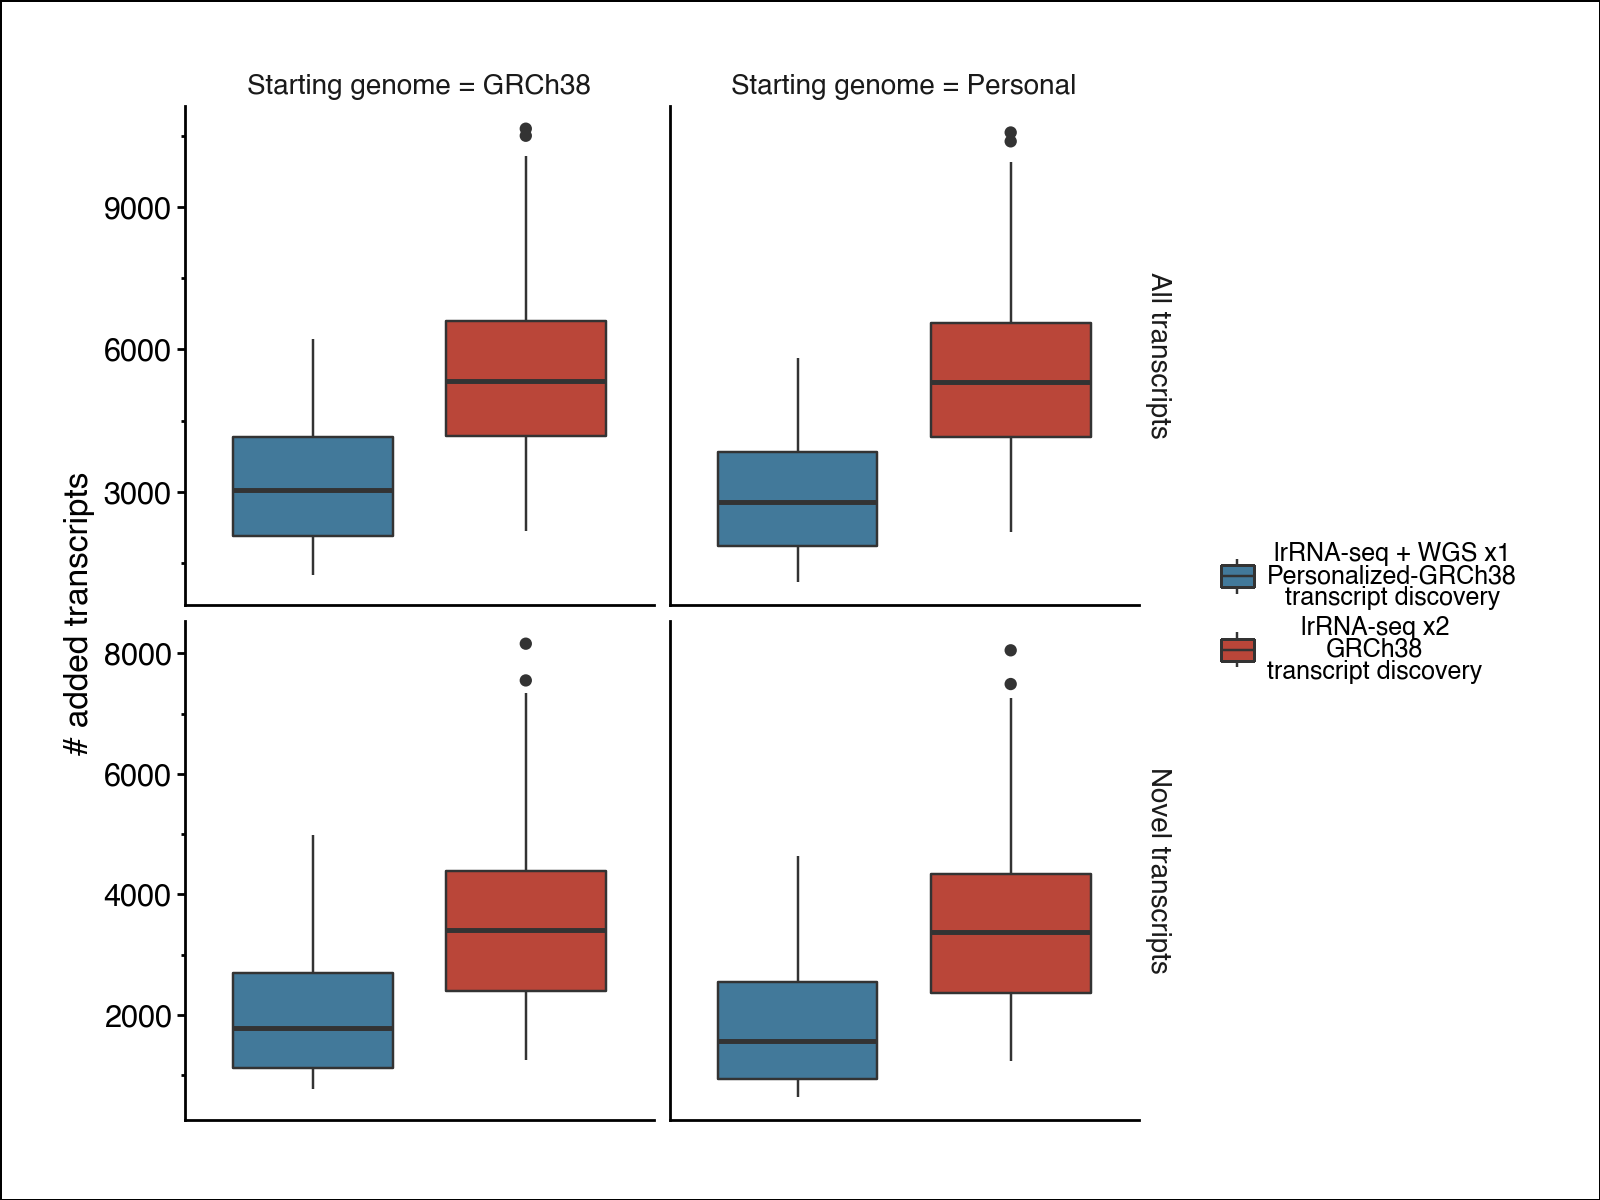

In [96]:
facet_row = 'ic_nov_hr'
facet_col = 'start_genome_hr'
fill = 'new_strat_hr'
y = 'n_ic_new'
x = 'new_strat_hr'

p = (ggplot(df, aes(y=y, x=x, fill=fill))
    + geom_boxplot()
    + scale_fill_manual(values=c_dict)
    + facet_grid(f'{facet_row}~{facet_col}', scales='free_y')
    + my_theme(h=6, w=8)
    + labs(
        y='# added transcripts',
        x='',
        fill='Added samples strategy'
    )
    + theme(
            axis_text_x=element_blank(),  # removes x tick labels
            axis_ticks_major_x=element_blank()  # removes x tick marks (optional)
        ))
p.show()

## Normalization: by million starting reads

In [98]:
df['n_ic_new_by_million_start_reads'] = (df['n_ic_new']/(df['start_n_reads']/1e6))

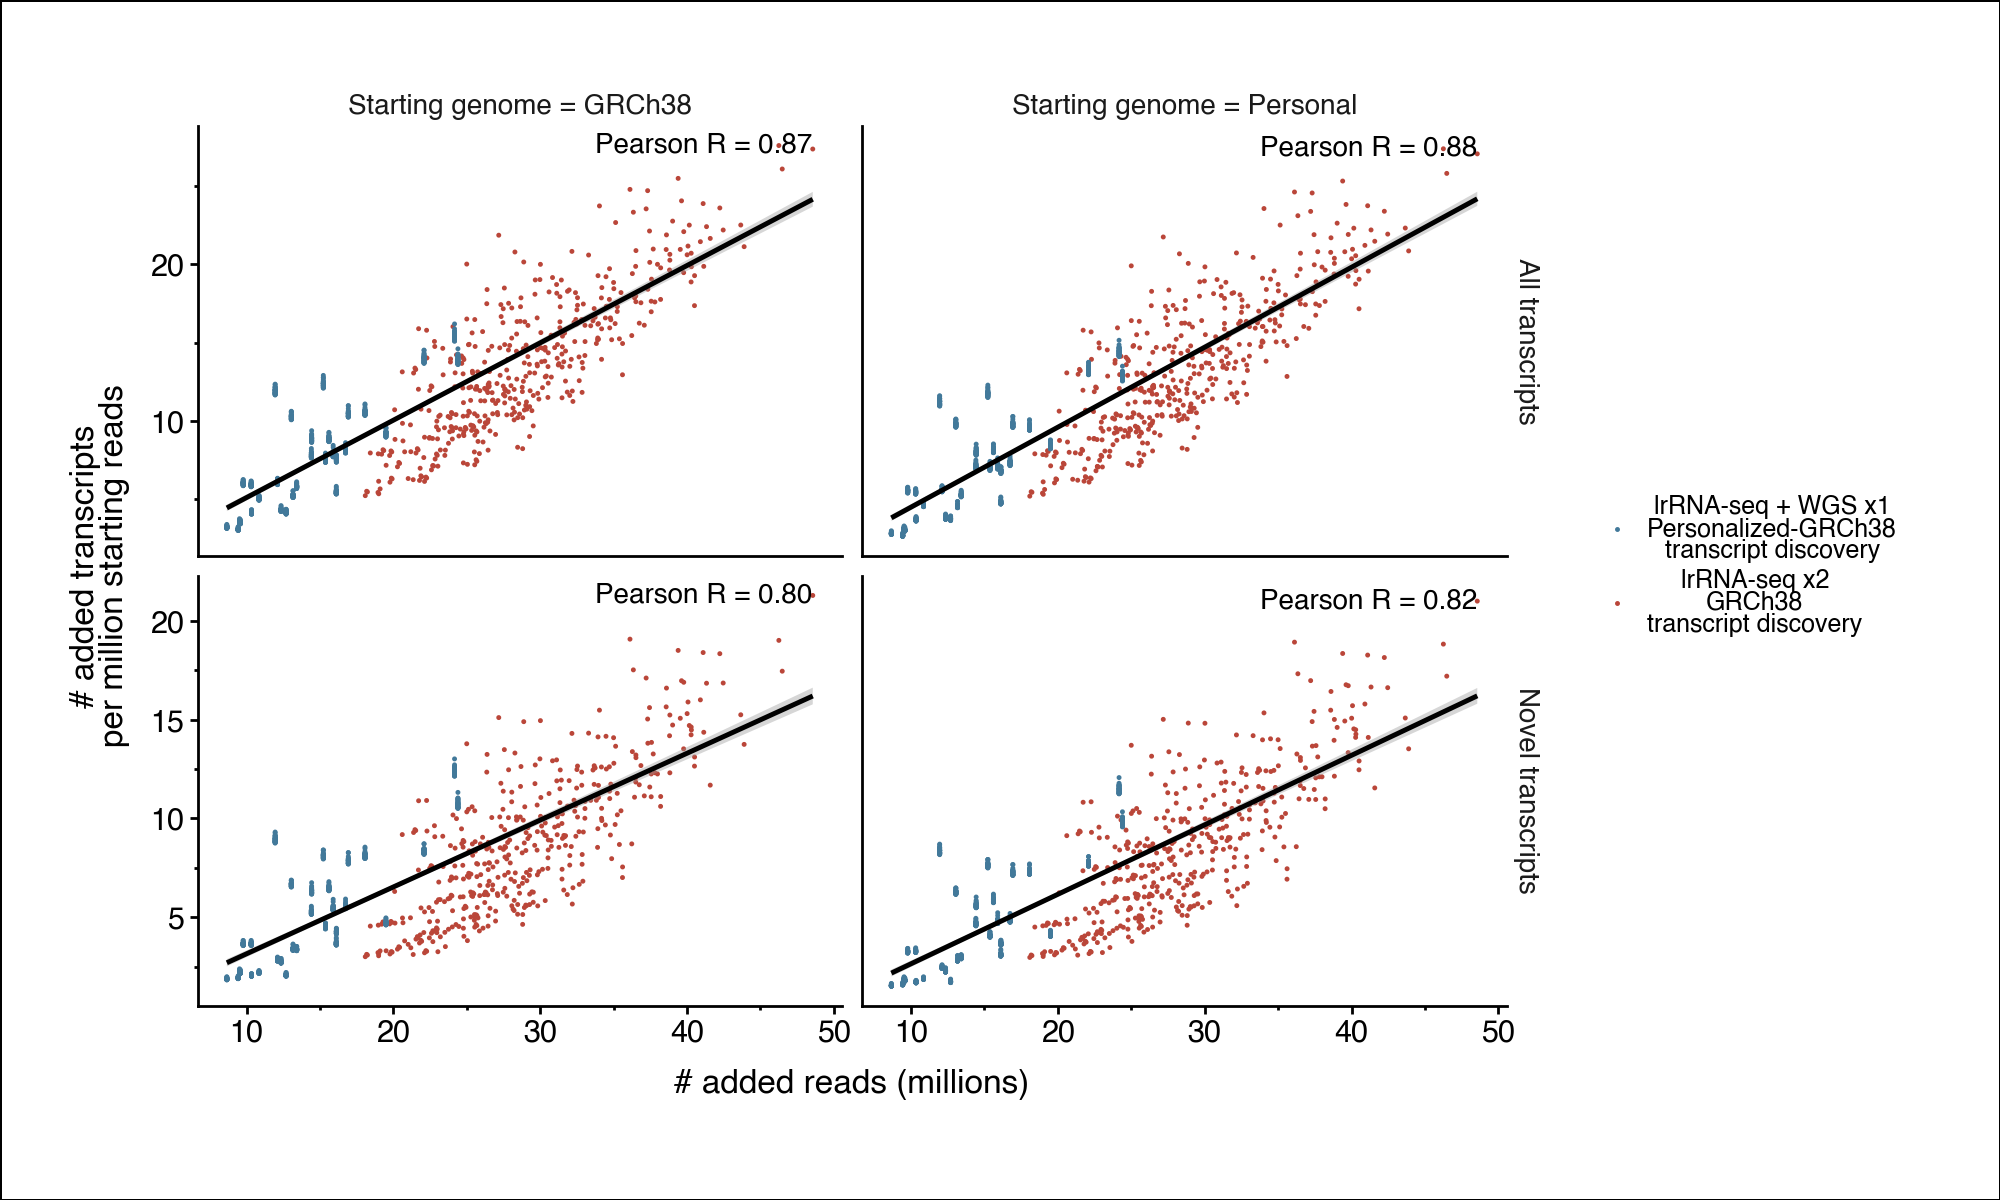

In [101]:
facet_col = 'start_genome_hr'
facet_row = 'ic_nov_hr'
fill = 'new_strat_hr'
x = 'new_n_reads_mil'
y = 'n_ic_new_by_million_start_reads'

anno_df = []
for (genome, nov), subdf in df.groupby([facet_col, facet_row]):
    r, p = st.pearsonr(subdf[x], subdf[y])
    label = f"Pearson R = {r:.2f}"
    x_pos = subdf[x].max()
    y_pos = subdf[y].max()
    anno_df.append({
        facet_col: genome,
        facet_row: nov,
        'label': label,
        'x': x_pos,
        'y': y_pos
    })
anno_df = pd.DataFrame(anno_df)


p = (ggplot(df, aes(x=x, y=y))
    + geom_point(aes(fill=fill), stroke=0, size=1)
    + scale_fill_manual(values=c_dict)
    + facet_grid(f'{facet_row}~{facet_col}', scales='free_y')
    + geom_smooth(method='lm')
    + geom_text(
        data=anno_df,
        mapping=aes(x='x', y='y', label='label'),
        inherit_aes=False,
        size=10,
        ha='right'
    )
    + my_theme(h=6, w=10)
    + labs(
        x='# added reads (millions)',
        y='# added transcripts\nper million starting reads',
        fill='Added samples strategy'
    ))
p.show()

In [ ]:
# so this method does not look like it solves the correlation between depth
# and # disc. ICs

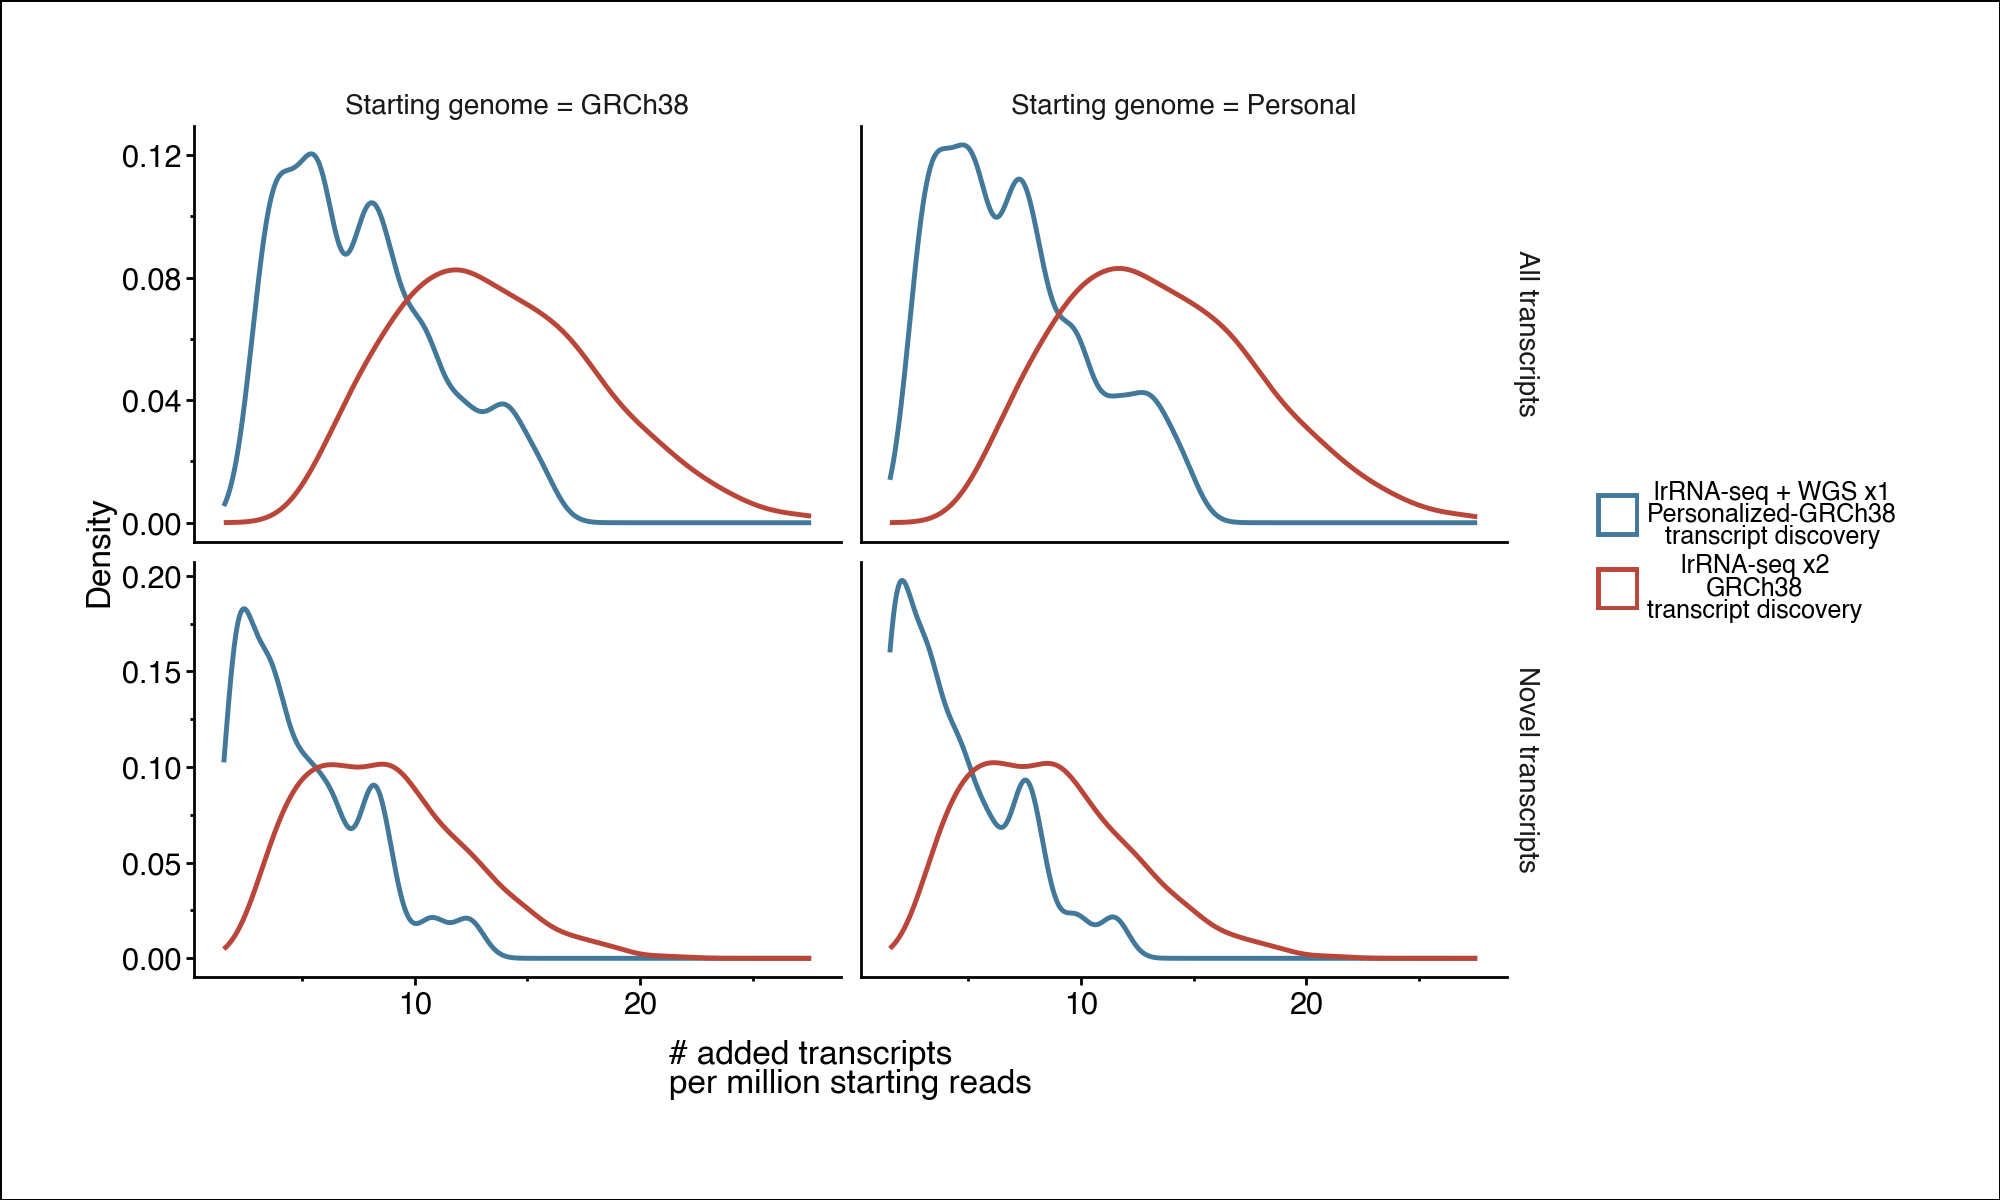

In [99]:
facet_row = 'ic_nov_hr'
facet_col = 'start_genome_hr'
color = 'new_strat_hr'
x = 'n_ic_new_by_million_start_reads'

p = (ggplot(df, aes(x=x))
    + geom_density(aes(color=color), size=1)
    + scale_color_manual(values=c_dict)
    + facet_grid(f'{facet_row}~{facet_col}', scales='free_y')
    + my_theme(h=6, w=10)
    + labs(
        x='# added transcripts\nper million starting reads',
        y='Density',
        fill='Added samples strategy'
    ))
p.show()

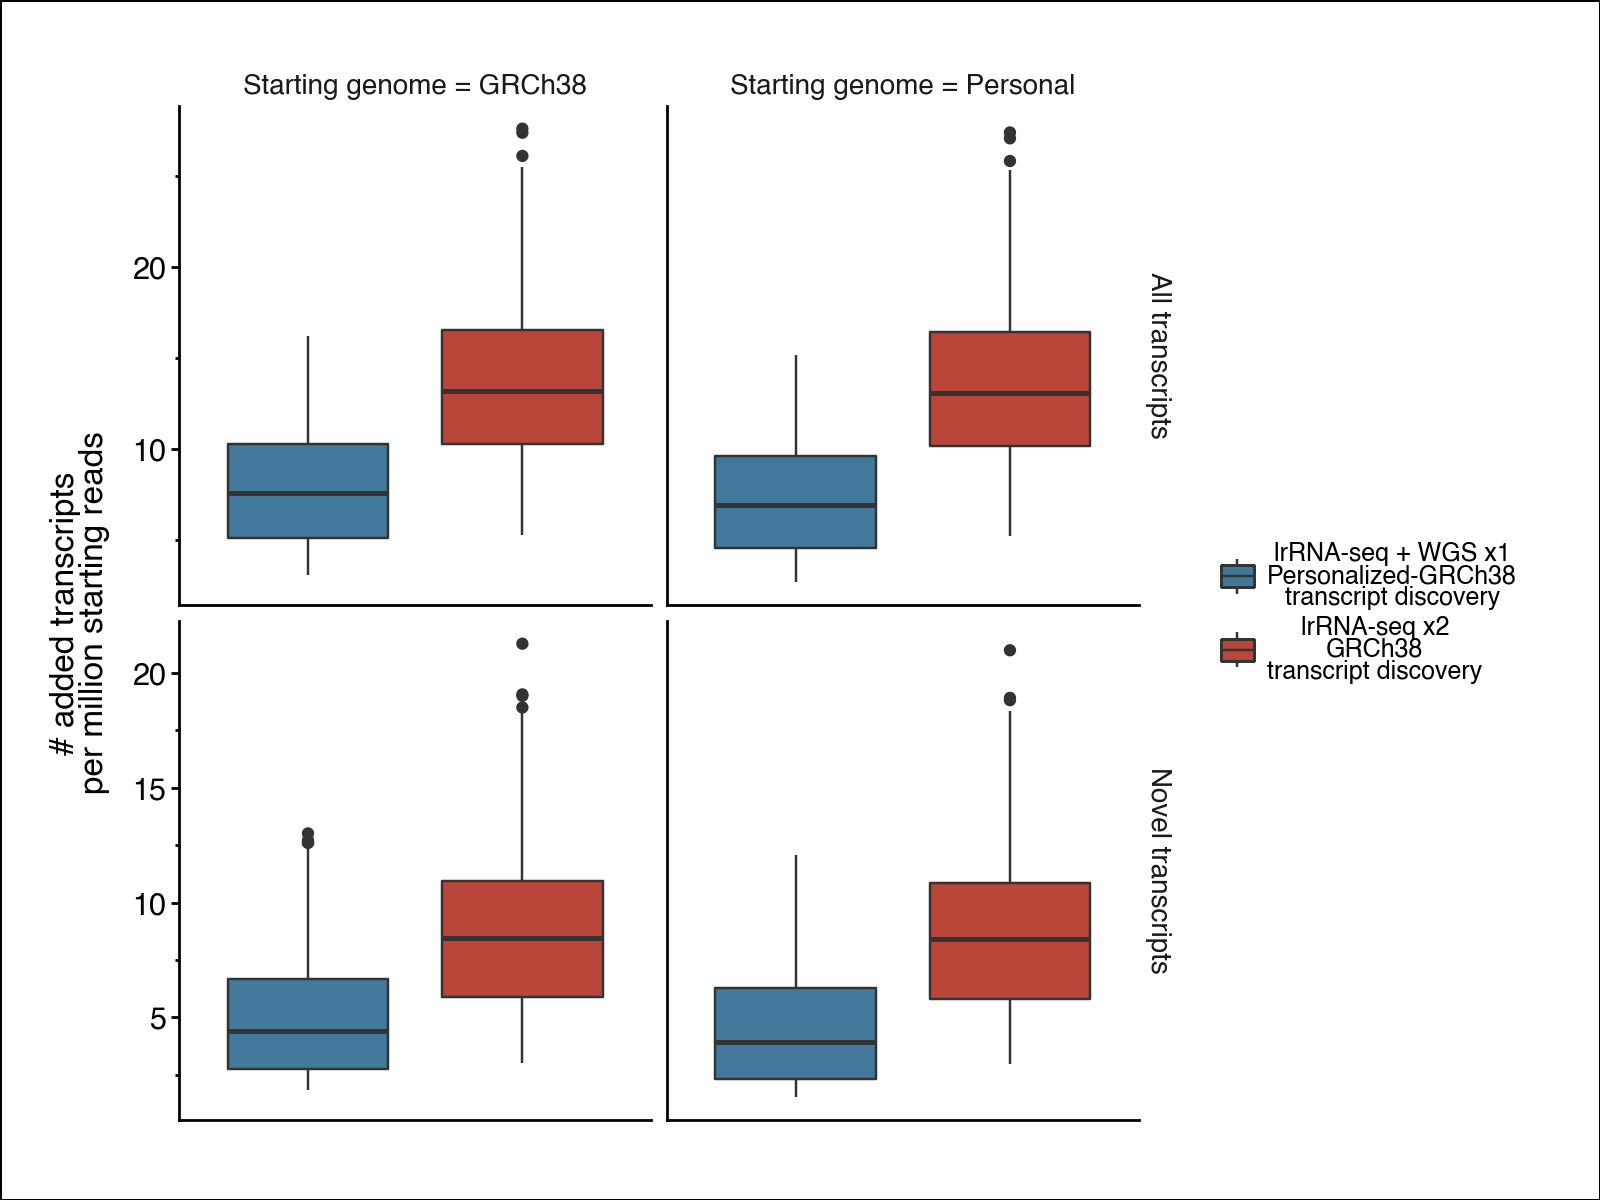

In [102]:
facet_row = 'ic_nov_hr'
facet_col = 'start_genome_hr'
fill = 'new_strat_hr'
y = 'n_ic_new_by_million_start_reads'
x = 'new_strat_hr'

p = (ggplot(df, aes(y=y, x=x, fill=fill))
    + geom_boxplot()
    + scale_fill_manual(values=c_dict)
    + facet_grid(f'{facet_row}~{facet_col}', scales='free_y')
    + my_theme(h=6, w=8)
    + labs(
        y='# added transcripts\nper million starting reads',
        x='',
        fill='Added samples strategy'
    )
    + theme(
            axis_text_x=element_blank(),  # removes x tick labels
            axis_ticks_major_x=element_blank()  # removes x tick marks (optional)
        ))
p.show()

## Normalization: by ratio of added reads:starting reads

In [106]:
df['n_ics_per_new_reads_ratio'] = (df.n_ic_new/(df.new_n_reads/df.start_n_reads))

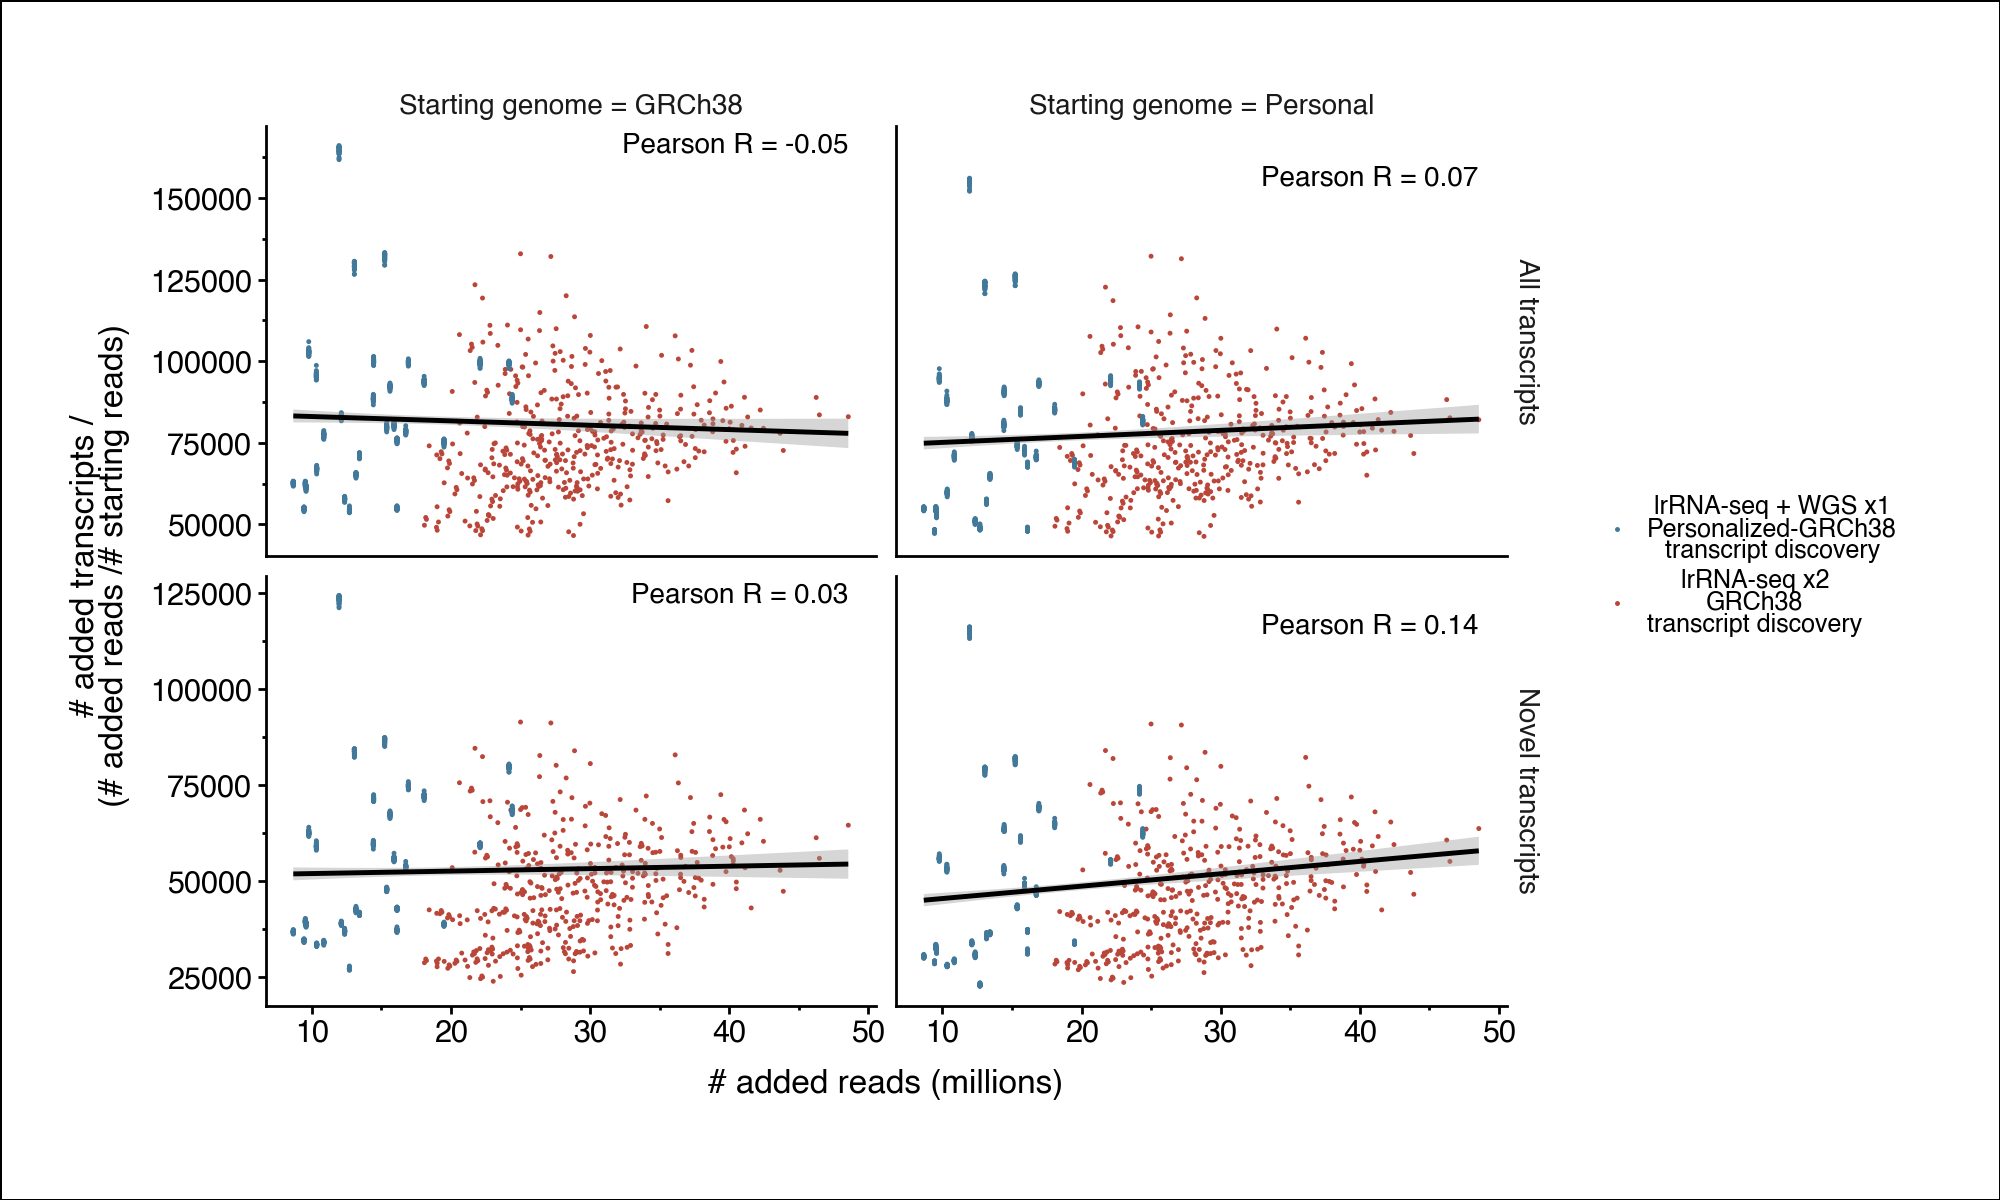

In [107]:
facet_col = 'start_genome_hr'
facet_row = 'ic_nov_hr'
fill = 'new_strat_hr'
x = 'new_n_reads_mil'
y = 'n_ics_per_new_reads_ratio'

anno_df = []
for (genome, nov), subdf in df.groupby([facet_col, facet_row]):
    r, p = st.pearsonr(subdf[x], subdf[y])
    label = f"Pearson R = {r:.2f}"
    x_pos = subdf[x].max()
    y_pos = subdf[y].max()
    anno_df.append({
        facet_col: genome,
        facet_row: nov,
        'label': label,
        'x': x_pos,
        'y': y_pos
    })
anno_df = pd.DataFrame(anno_df)


p = (ggplot(df, aes(x=x, y=y))
    + geom_point(aes(fill=fill), stroke=0, size=1)
    + scale_fill_manual(values=c_dict)
    + facet_grid(f'{facet_row}~{facet_col}', scales='free_y')
    + geom_smooth(method='lm')
    + geom_text(
        data=anno_df,
        mapping=aes(x='x', y='y', label='label'),
        inherit_aes=False,
        size=10,
        ha='right'
    )
    + my_theme(h=6, w=10)
    + labs(
        x='# added reads (millions)',
        y='# added transcripts /\n(# added reads /# starting reads)',
        fill='Added samples strategy'
    ))
p.show()

In [ ]:
# gets rid of the correlation

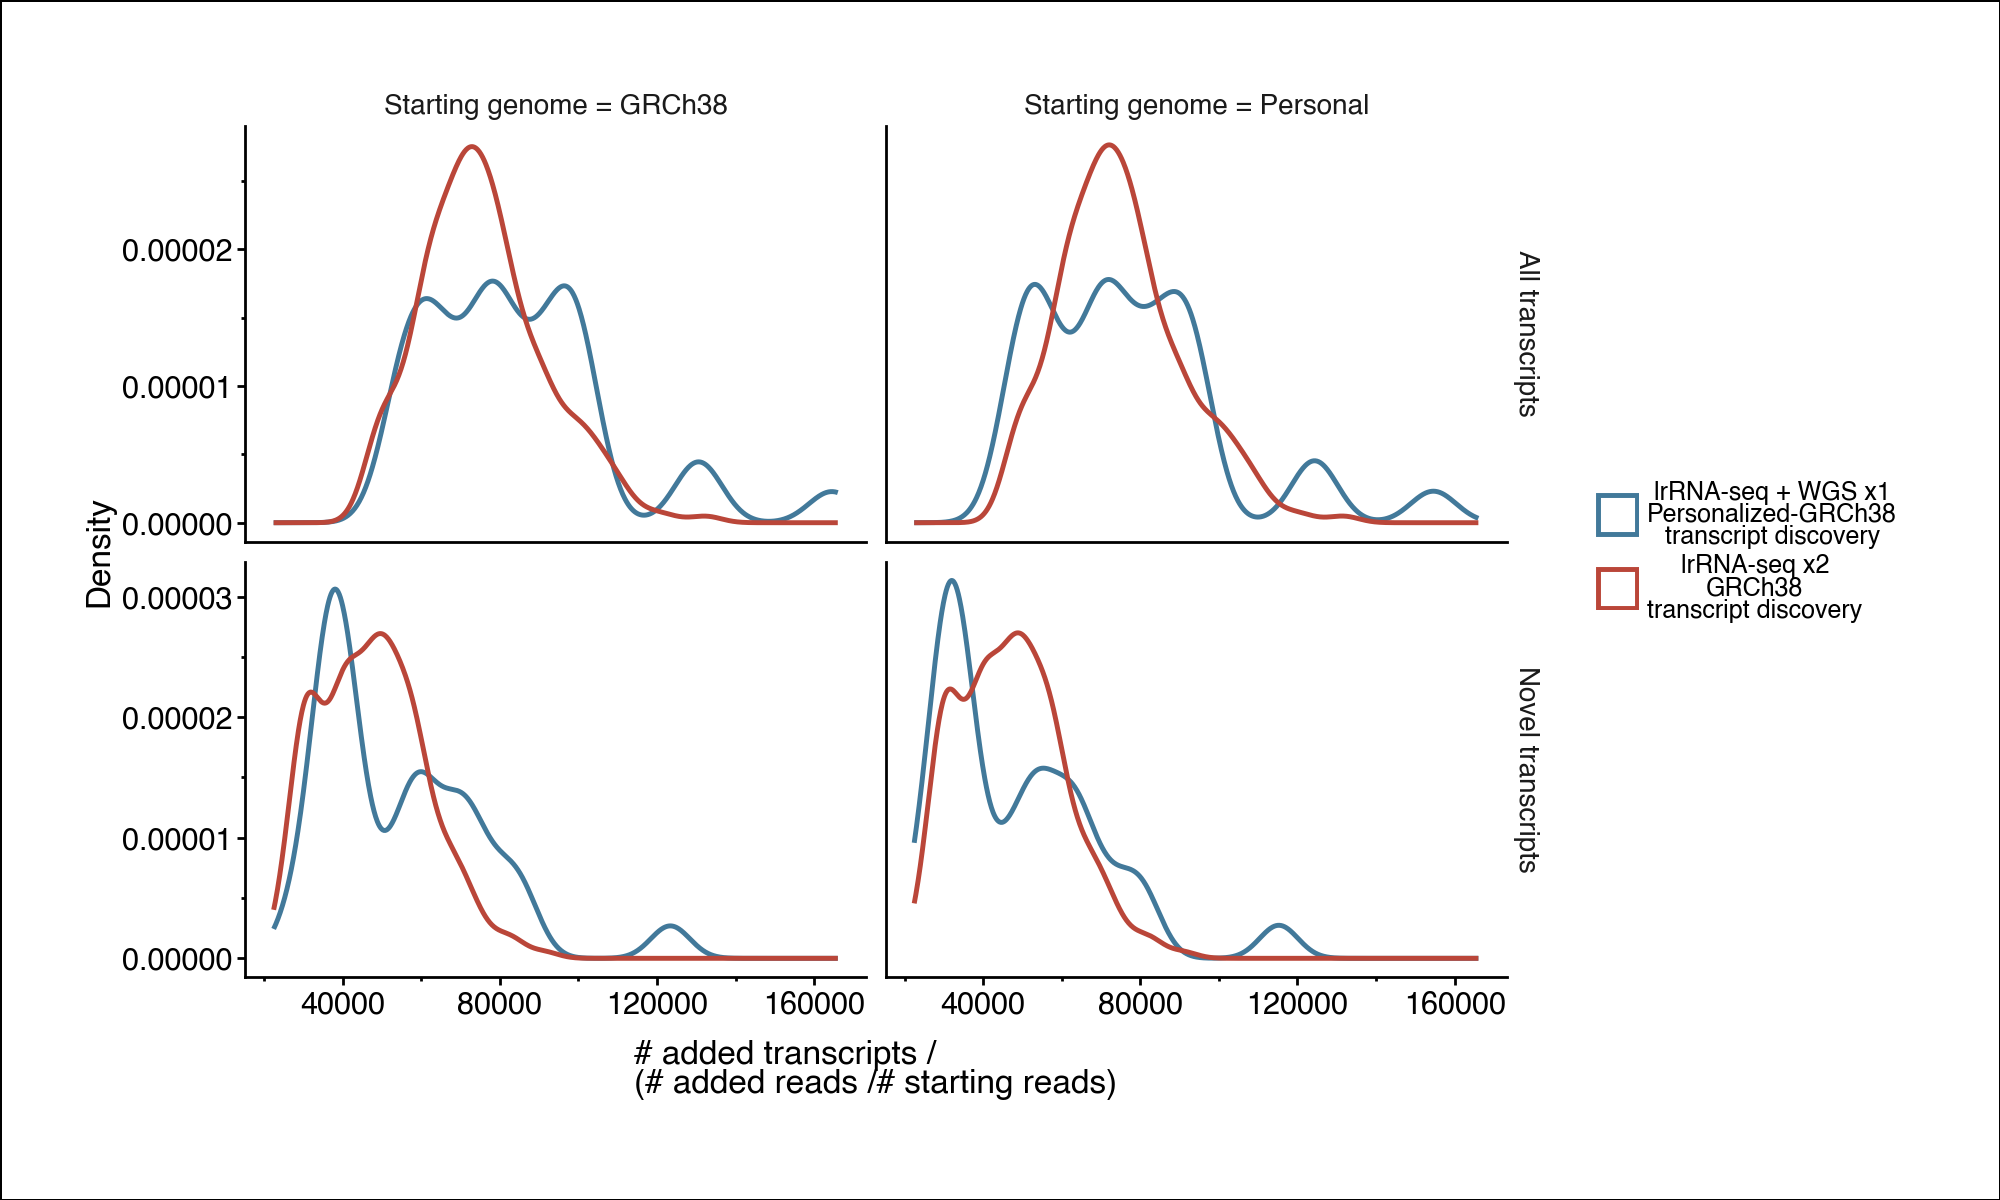

In [108]:
facet_row = 'ic_nov_hr'
facet_col = 'start_genome_hr'
color = 'new_strat_hr'
x = 'n_ics_per_new_reads_ratio'

p = (ggplot(df, aes(x=x))
    + geom_density(aes(color=color), size=1)
    + scale_color_manual(values=c_dict)
    + facet_grid(f'{facet_row}~{facet_col}', scales='free_y')
    + my_theme(h=6, w=10)
    + labs(
        x='# added transcripts /\n(# added reads /# starting reads)',
        y='Density',
        fill='Added samples strategy'
    ))
p.show()

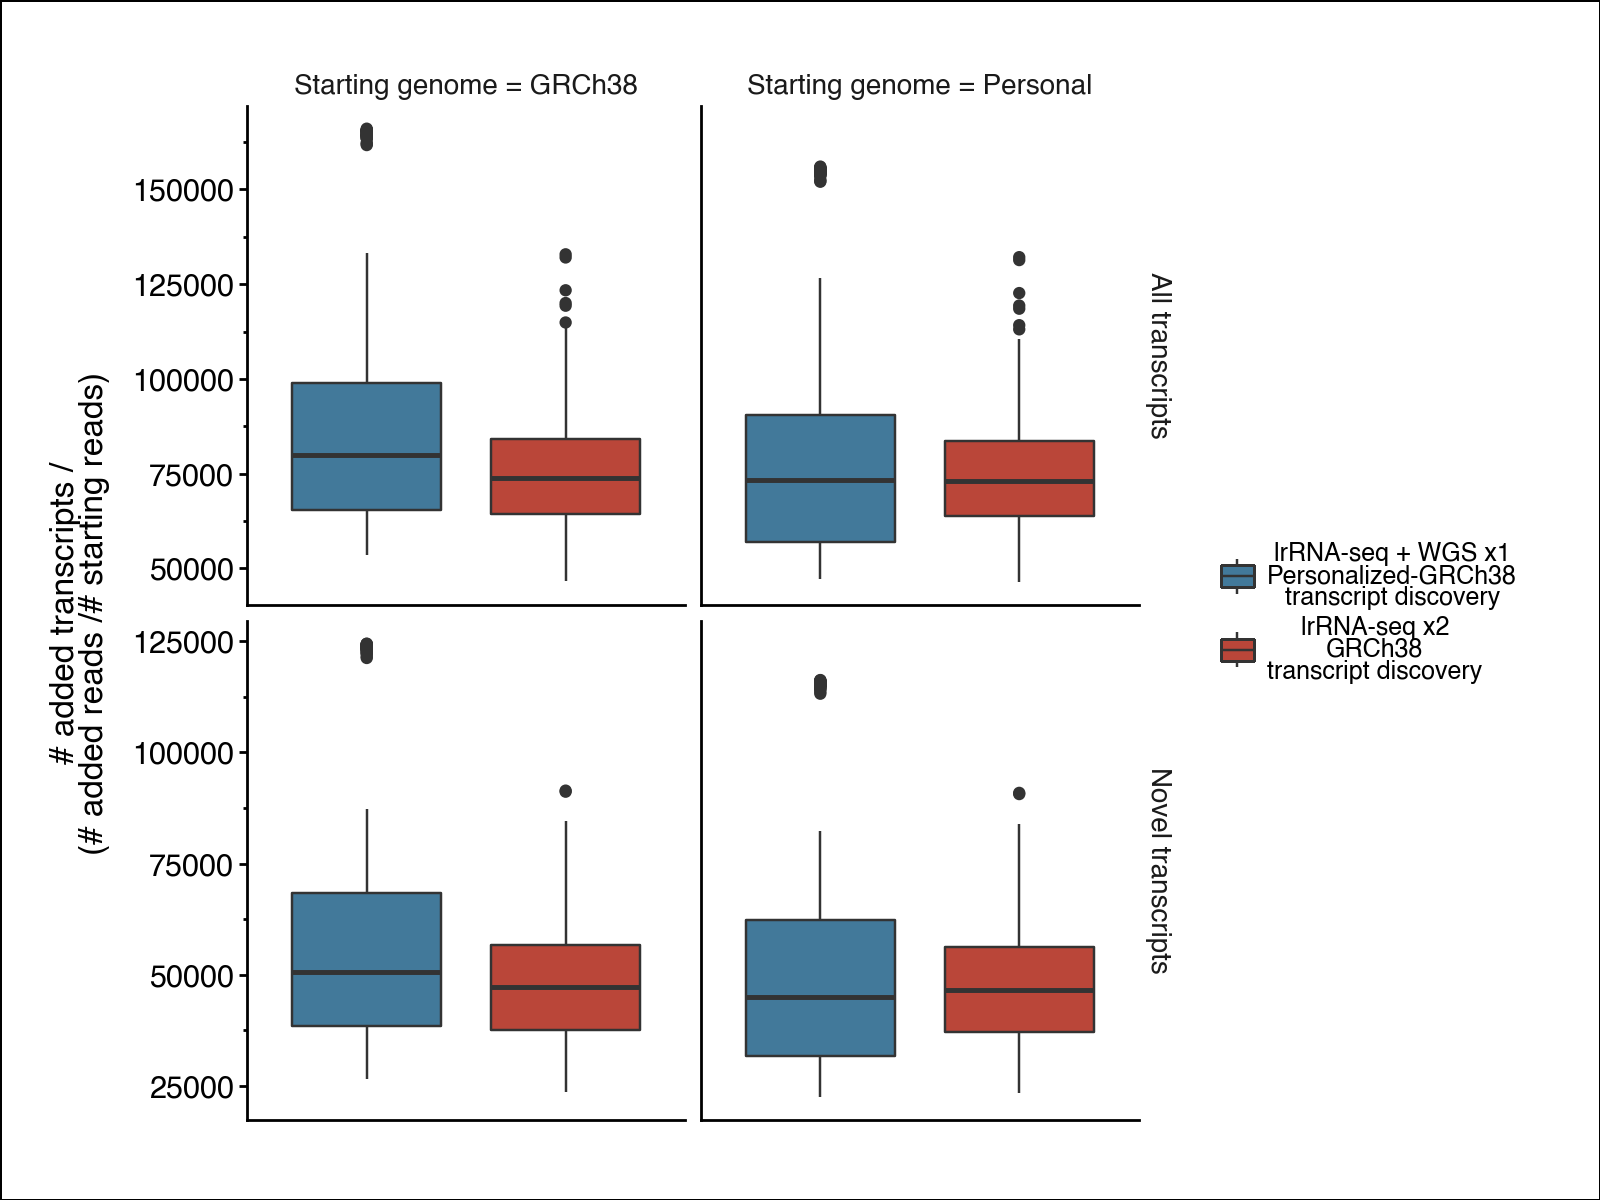

In [109]:
facet_row = 'ic_nov_hr'
facet_col = 'start_genome_hr'
fill = 'new_strat_hr'
y = 'n_ics_per_new_reads_ratio'
x = 'new_strat_hr'

p = (ggplot(df, aes(y=y, x=x, fill=fill))
    + geom_boxplot()
    + scale_fill_manual(values=c_dict)
    + facet_grid(f'{facet_row}~{facet_col}', scales='free_y')
    + my_theme(h=6, w=8)
    + labs(
        y='# added transcripts /\n(# added reads /# starting reads)',
        x='',
        fill='Added samples strategy'
    )
    + theme(
            axis_text_x=element_blank(),  # removes x tick labels
            axis_ticks_major_x=element_blank()  # removes x tick marks (optional)
        ))
p.show()

In [111]:
df.to_csv('250718_ic_discovery_28_sample_experiment.tsv', sep='\t')